<a id="top"></a>
# Chunking Demo (WOFS)

<hr>

# Notebook Summary

This notebook demonstrates how to load and process data in chunks to avoid running out of memory (causing `MemoryError` errors). The Australian Water Observations from Space (WOFS) algorithm is used to detect water. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 
<br><br>
For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube](#load_data)
* [Time Series Water Detection Analysis](#analysis)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import warnings
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  

# Supress Warning 
warnings.filterwarnings('ignore')

api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platform and Product [&#9652;](#top)</span>

In [2]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

#product = "ls7_ledaps_senegal"
#platform = "LANDSAT_7"

product = "ls8_lasrc_senegal"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_max_dates[0], min_max_dates[1]))))

Latitude Extents: (12.20184, 17.082576)
Longitude Extents: (-18.32754, -10.82991)
Time Extents: ['2013-04-12', '2018-02-01']


**Visualize the available area**

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

# <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Be sure you check whether you are using L7 or L8 as the time extents are very different
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the water assessment

# Southern Lake Guiers - Senegal
# lat = (15.9785, 16.1316 ) 
# lon = (-15.9789, -15.8519) 

# Northern Lake Guiers - Senegal
# lat =  (16.1555, 16.397 ) 
# lon = (-15.9047, -15.7184) 

# Lake Guiers - Senegal
lat = (15.925, 16.40)
lon = (-15.975, -15.75)

# Random Lake - Senegal
# lat =  (14.8695, 14.8954 ) 
# lon = (-17.0633, -17.0431) 

# Lake Retba - Senegal
# lat =  (14.7543, 14.7721) 
# lon = (-17.4143, -17.3948)

# East of Niokolo bar, Senegal
#lat = (13.1710, 13.2304)
#lon  = (-12.1627, -12.0930)
#time_extents = ('01/02/2000', '01/24/2018')

# Mako Forest, Senegal
# lat = (12.7774, 12.9963)
# lon = (-12.5275, -12.2780)

# Niokolo koba, Senegal
# lat = (12.5431, 13.4464)
# lon = (-13.7666, -12.2484)

time_extents = ('01/01/2016', '12/31/2018') # MM/DD/YYYY

**Visualize the available area**

In [6]:
display_map(lat, lon)

## <span id="load_data">Load Data from the Data Cube [&#9652;](#top)</span>

Large data sets must be broken up into smaller geographic "chunks" and processed one at at time. If you see a `MemoryError`, chunking may be the appropriate solution.

The basic chunking process is:
1. Perform a load of the full analysis region without measurements to get metadata needed for chunking.
2. Create a result `DataArray` that is large enough to hold the output (WOFS percentages in this case) for the entire
   analysis region.
3. Split the dataset into smaller geographic chunks.
4. Mask out the clouds from each chunk.
5. Run WOFS on the chunk.
6. Add the results to the result `DataArray`.

In [7]:
# loading with no measurements loads coordinates and dimensions only. 
# We can use this to properly size our result dataset.
metadata = dc.load(latitude = lat, longitude = lon,
                   platform = platform,
                   time = time_extents,
                   product = product,
                   measurements = []) 

After loading, you will view the xarray `Dataset`. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [8]:
metadata

<xarray.Dataset>
Dimensions:    (latitude: 1753, longitude: 811, time: 92)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-11T11:26:44 ... 2018-02-01T11:26:56
  * latitude   (latitude) float64 16.4 16.4 16.4 16.4 ... 15.93 15.93 15.92
  * longitude  (longitude) float64 -15.98 -15.97 -15.97 ... -15.75 -15.75 -15.75
Data variables:
    *empty*
Attributes:
    crs:      EPSG:4326

Here we create a `DataArray` that is large enough to hold the WOFS percentages for the entire analysis region. Only the latitude and longitude dimensions are of interest in the final result so we drop the time dimension to save memory.

In [9]:
num_lats, num_lons = [metadata.dims[key] for key in ['latitude', 'longitude']]
metadata_coords = dict(metadata.coords)
del metadata_coords['time']
water_percents = xr.DataArray(np.full((num_lats, num_lons), np.nan), 
                              dims=('latitude', 'longitude'), 
                              coords=metadata_coords, attrs=metadata.attrs)

The analysis region is split into smaller chunks according to the given `geographic_chunk_size` in degrees. For larger time ranges a smaller `geographic_chunk_size` should be used. However, the smaller the chunk size the longer the notebook will take to run as it will spend more time loading data from the datacube which is an expensive operation.

In [10]:
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks

geographic_chunks = create_geographic_chunks(latitude=lat, longitude=lon, 
                                             geographic_chunk_size=0.05)

Each geographic chunk is loaded from the datacube, the clouds are masked out, and the WOFS percentages are computed for that chunk. The results are copied into the corresponding chunk of the `water_percents` result `DataArray`.

In [11]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
for chunk_ind, geographic_chunk in enumerate(geographic_chunks):
    lon_chunk, lat_chunk = geographic_chunk.values()
    dataset_chunk = dc.load(latitude = lat_chunk, longitude = lon_chunk,
                            platform = platform,
                            time = time_extents,
                            product = product,
                            measurements = measurements)
    if not len(dataset_chunk) == 0: # If this chunk has any data...
        # `clean_mask_chunk` keeps clear views of land and water (no clouds).
        clean_mask_chunk = landsat_qa_clean_mask(dataset_chunk, platform=platform)
        dataset_chunk = dataset_chunk.drop('pixel_qa').where(clean_mask_chunk)
        wofs_chunk = wofs_classify(dataset_chunk, clean_mask=clean_mask_chunk.values)
        wofs_chunk = wofs_chunk.where(wofs_chunk != -9999)
        water_percents_chunk = (wofs_chunk.mean(dim = ['time']) * 100).wofs.rename('water_percents_chunk')
        chunk_selector = {'latitude':slice(*lat_chunk[::-1]), 
                          'longitude':slice(*lon_chunk)}
        water_percents.loc[chunk_selector].values[:] = \
            water_percents_chunk.loc[chunk_selector].values
        
    print("\rProcessed {} out of {} chunks ({:.2%})."
          .format(chunk_ind+1, len(geographic_chunks), 
                  (chunk_ind+1)/len(geographic_chunks)), end='')

Processed 3 out of 3 chunks (100.00%).

## <span id="analysis">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [12]:
# import color-scheme and set nans to black
from matplotlib.cm import jet_r as jet_r
jet_r.set_under('black',1)

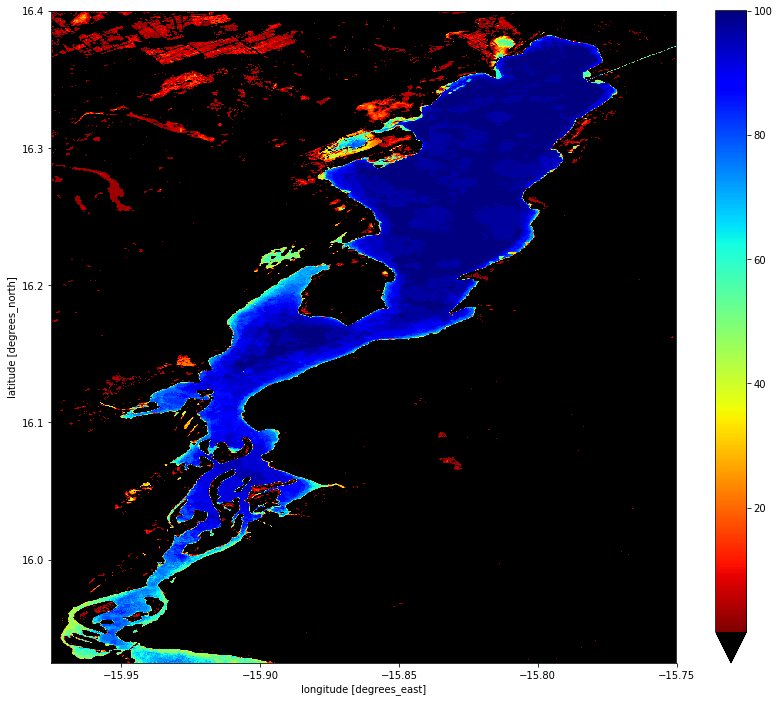

In [13]:
# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

# The "figsize" may need adjustment to get the proper scaling and avoid distortion. 
# See the XARRAY dimensions above to get an idea of the Lat-Lon ratio for your image, figsize=(x,y)
# The y-axis scale and legend is part of the image area, so that needs to be considered
# It is suggested to keep the x-dimension at x=12. 

water_percents.plot(cmap = jet_r, vmin=0.001, figsize=(14,12))
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [14]:
# Save the water percentage data to a GeoTIFF
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# ts_water_classification
dataset_to_export = xr.Dataset(coords=water_percents.coords,attrs=water_percents.attrs)
dataset_to_export['wofs_pct'] = (water_percents/100).astype(np.float32)

<xarray.Dataset>
Dimensions:    (latitude: 1753, longitude: 811)
Coordinates:
  * latitude   (latitude) float64 16.4 16.4 16.4 16.4 ... 15.93 15.93 15.92
  * longitude  (longitude) float64 -15.98 -15.97 -15.97 ... -15.75 -15.75 -15.75
Data variables:
    wofs_pct   (latitude, longitude) float32 nan 0.028571429 ... nan nan
Attributes:
    crs:      EPSG:4326


In [18]:
import os

# The export command below is commented out to avoid overwriting files. 
# If you would like to export data, please check the file path before uncommenting the line
# to ensure no files are accidentally lost.

output_dir = 'geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# export_slice_to_geotiff(dataset_to_export, output_dir + '/Chunking_Demo_WOFS.tif')

In [19]:
!ls -lah geotiffs/Chunking_Demo_WOFS.tif

total 5.5M
drwxrwxr-x  2 localuser localuser 4.0K Sep 27 21:43 .
drwxr-xr-x 15 localuser localuser 4.0K Sep 27 21:43 ..
-rw-rw-r--  1 localuser localuser 5.5M Sep 27 21:43 Chunking_Demo_WOFS.tif


In [ ]:
!gdalinfo geotiffs/Chunking_Demo_WOFS.tif